<a href="https://colab.research.google.com/github/abrar39/kaggle_playground/blob/master/Binary_Prediction_with_a_Rainfall_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook contains the code for predicting the rainfall in the [Kaggle Playground series Challenge](https://www.kaggle.com/competitions/playground-series-s5e3/overview) started on 01-03-2025 and ended on 31-03-2025. The dataset for this competition (both train and test) was generated from a deep learning model trained on the [Rainfall Prediction](https://www.kaggle.com/datasets/subho117/rainfall-prediction-using-machine-learning) using Machine Learning dataset. Feature distributions are close to, but not exactly the same, as the original.

## Objective
Your goal is to predict rainfall for each day of the year.

## Evaluation Criteria
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

# Setup

In [1]:
# Install Kaggle
!pip install kaggle

In [2]:
# Import the Kaggle API JSON from google drive into notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Shift the kaggle json from drive to the working space
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/ML/Kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset
!kaggle competitions download -c playground-series-s5e3

  0% 0.00/59.0k [00:00<?, ?B/s]
100% 59.0k/59.0k [00:00<00:00, 69.6MB/s]


In [5]:
# unzip the dataset
!unzip playground-series-s5e3.zip

Archive:  playground-series-s5e3.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Import Necessary Libraries and dataset

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, shapiro

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [7]:
train_path = r'/content/train.csv'
test_path = r'/content/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# EDA

In [8]:
train_df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [9]:
train_df.shape

(2190, 13)

In [10]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2190.0,1094.500000,632.342866,0.0,547.250,1094.50,1641.750,2189.0
day,2190.0,179.948402,105.203592,1.0,89.000,178.50,270.000,365.0
pressure,2190.0,1013.602146,5.655366,999.0,1008.600,1013.00,1017.775,1034.6
maxtemp,2190.0,26.365799,5.654330,10.4,21.300,27.80,31.200,36.0
temparature,2190.0,23.953059,5.222410,7.4,19.300,25.50,28.400,31.5
mintemp,2190.0,22.170091,5.059120,4.0,17.700,23.85,26.400,29.8
dewpoint,2190.0,20.454566,5.288406,-0.3,16.800,22.15,25.000,26.7
humidity,2190.0,82.036530,7.800654,39.0,77.000,82.00,88.000,98.0
cloud,2190.0,75.721918,18.026498,2.0,69.000,83.00,88.000,100.0
sunshine,2190.0,3.744429,3.626327,0.0,0.400,2.40,6.800,12.1


**Observations About Data**
1. There appears to be no missing data.
2. All the features are numerical.
3. `day` is the day of the year. The data is for 06 years. (365 * 6 = 2190).
4. About 75% of the data has a positive class.

In [11]:
def scatter_plot_of_conditions(x: str, y: str, ax: plt.Axes):
  """
  Plot the scatter of x, and y with color label as rainfall
  """
  # Plot a scatter plot of pressure with rainfall as color of the dots.
  #fig, ax = plt.subplots(figsize=(6,6))
  scatter = ax.scatter(train_df[x], train_df[y], c=train_df['rainfall'], cmap='viridis')
  # Display the color label as legend
  legend = ax.legend(*scatter.legend_elements(), title="Rainfall")
  ax.add_artist(legend)
  ax.set_xlabel(x)
  ax.set_ylabel(y)
  ax.set_title(f'{x} vs {y}')


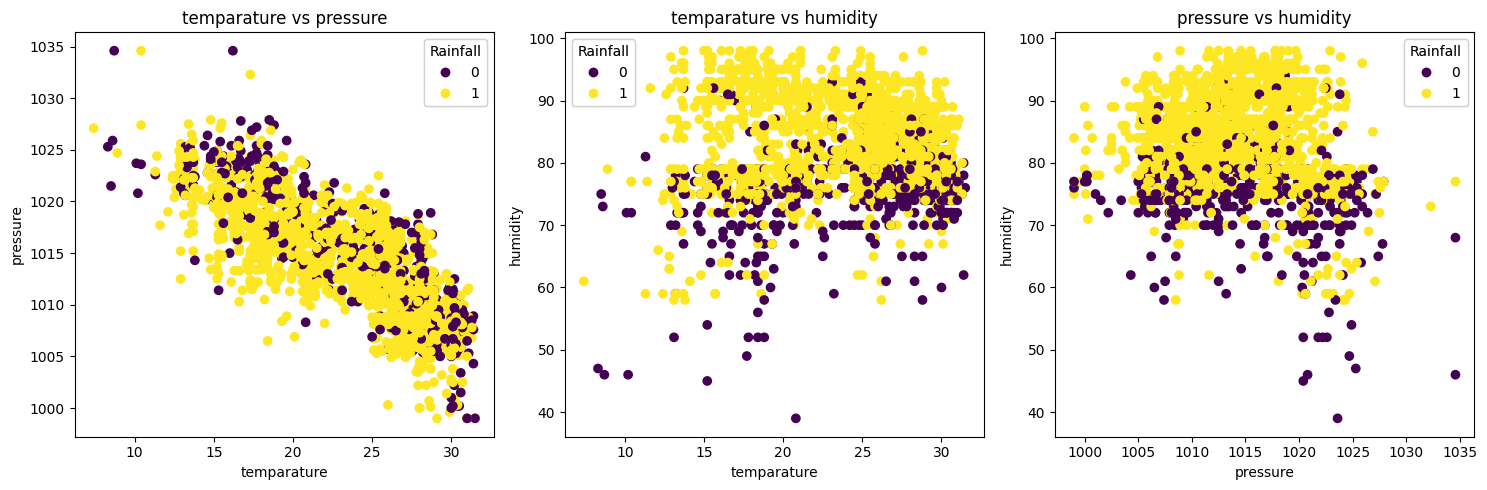

In [12]:
# Create a subplot with three axes
plot_features = [('temparature', 'pressure'), ('temparature', 'humidity'), ('pressure', 'humidity')]
num_plots = len(plot_features)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(num_plots):
  x, y = plot_features[i]
  scatter_plot_of_conditions(x, y, axs[i])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

### Correlation between `rainfall` and different features

**Point Biserial Correlation** is used to measure the correlation between a dichotomous and a metric/ continuous variable. The metric variable should be approximately normally distributed for both groups. Therefore, first we shall check for normality then apply Point Bisearial Correlation.

In [16]:
def check_normality(variable: str):
  """
  Check if the variable is normally distributed using Shapiro-Wilk test
  and print the results.
  Shapiro-Wilk Test: p-value > 0.05 indicates normality.
  """
  stat, p_value = shapiro(train_df[variable])
  print(f'Shapiro-Wilk test for {variable}: statistic={stat}, p-value={p_value}')

In [15]:
continuous_variables = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
for continuous_variable in continuous_variables:
  check_normality(continuous_variable)

Shapiro-Wilk test for pressure: statistic=0.9763156836452379, p-value=1.3541650895025296e-18
Shapiro-Wilk test for maxtemp: statistic=0.9376810211758063, p-value=2.2276579749730124e-29
Shapiro-Wilk test for temparature: statistic=0.926075849637032, p-value=1.4851048714619923e-31
Shapiro-Wilk test for mintemp: statistic=0.9225954302011259, p-value=3.728340679774066e-32
Shapiro-Wilk test for dewpoint: statistic=0.8924406632537085, p-value=1.2757738135106006e-36
Shapiro-Wilk test for humidity: statistic=0.9699158718680774, p-value=5.122586876400622e-21
Shapiro-Wilk test for cloud: statistic=0.838014950926085, p-value=1.3265699492608219e-42
Shapiro-Wilk test for sunshine: statistic=0.8678626528912328, p-value=1.4374321948273875e-39
Shapiro-Wilk test for winddirection: statistic=0.8335300085154858, p-value=5.0919279065879915e-43
Shapiro-Wilk test for windspeed: statistic=0.9521411486320854, p-value=3.5555787681875404e-26


In [31]:
num_bins = int(np.ceil(np.sqrt(len(train_df))))
num_bins

47

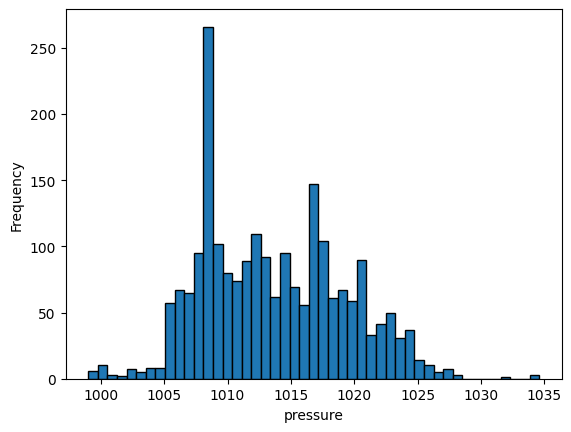

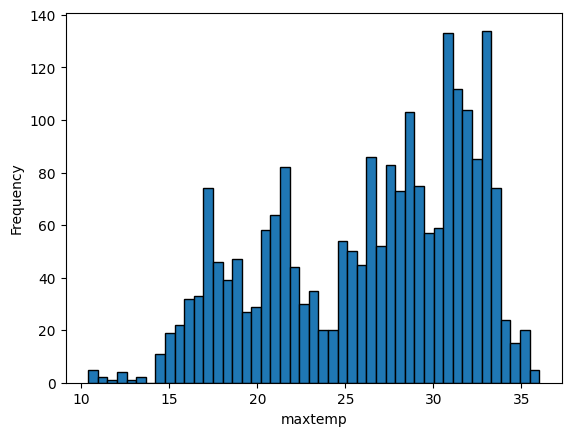

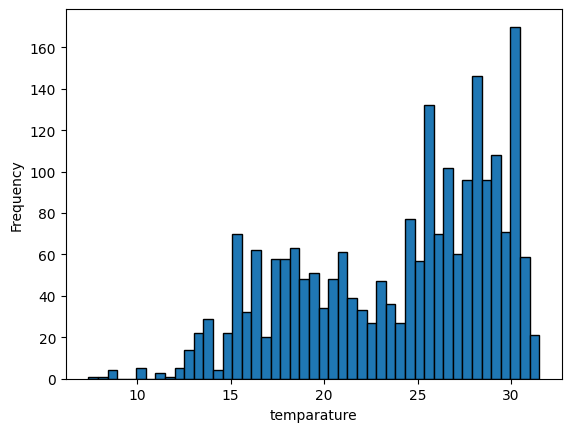

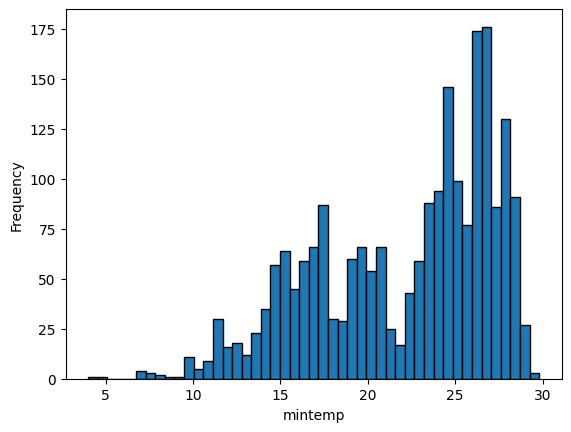

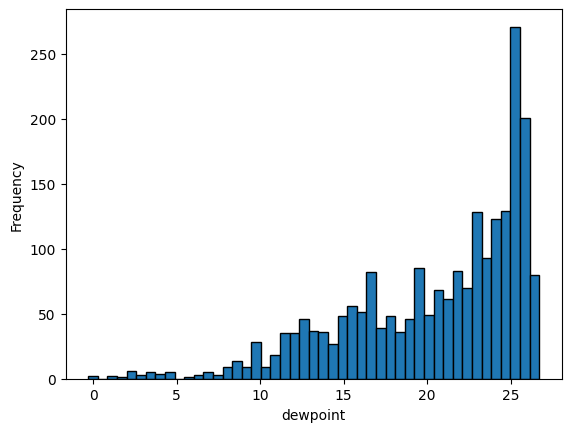

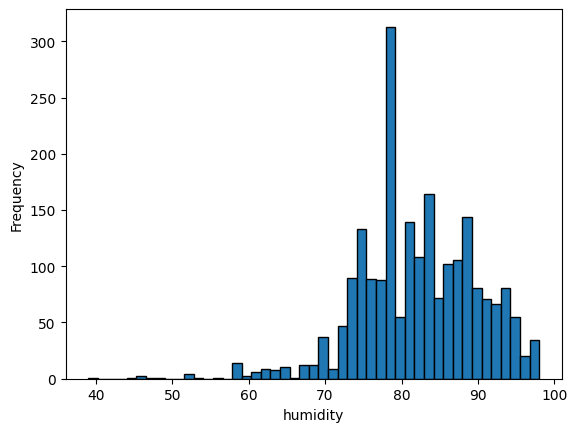

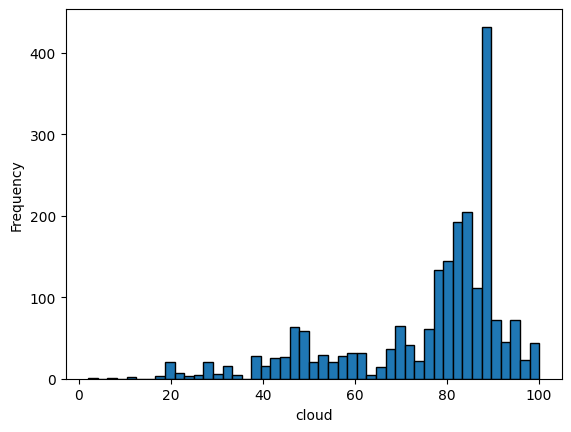

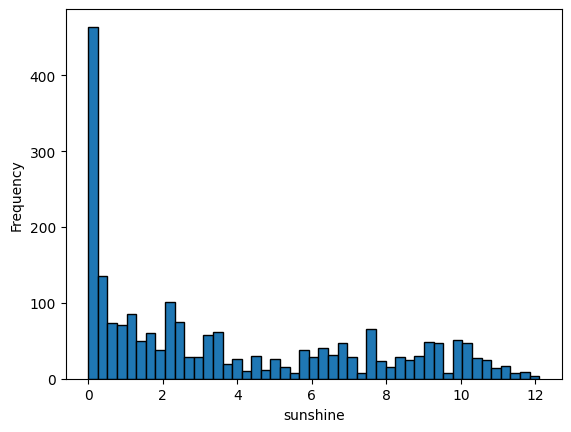

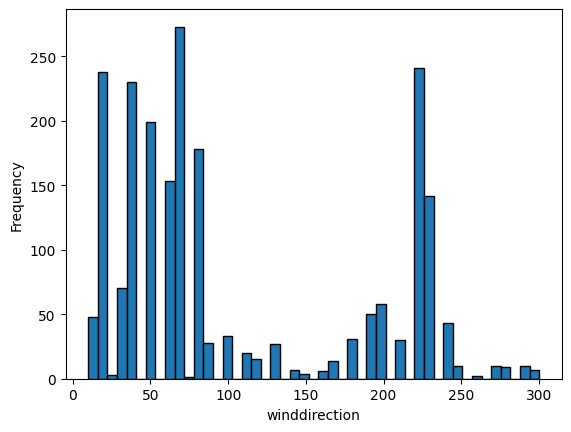

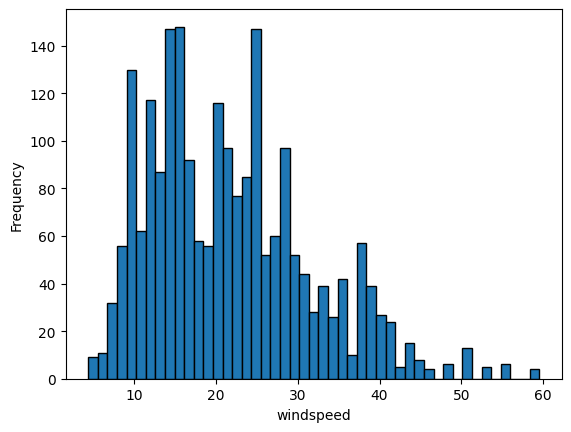

In [32]:
def plot_histogram(variable: str):
  """
  Plot histogram of the variable
  """
  plt.hist(train_df[variable], bins=num_bins, edgecolor='black')
  plt.xlabel(variable)
  plt.ylabel('Frequency')
  plt.show()

for continuous_variable in continuous_variables:
  plot_histogram(continuous_variable)

The calculates statistics and the histograms shuggest that the variables are not normally distributed. Therefore, point biserial correlation might not be reliable.

In [33]:
def compute_pointbiserialr_corr(continuous_variable: str, discrete_variable: str = 'rainfall'):
  r, p_value = pointbiserialr(train_df[discrete_variable], train_df[continuous_variable])
  print(f'Point Biserial Correlation between {discrete_variable} and {continuous_variable}: {r}, p-value: {p_value}')

In [35]:
for continuous_variable in continuous_variables:
  compute_pointbiserialr_corr(continuous_variable)

Point Biserial Correlation between rainfall and pressure: -0.04988554522612454, p-value: 0.01956242585968942
Point Biserial Correlation between rainfall and maxtemp: -0.07930352093398049, p-value: 0.00020325639049202925
Point Biserial Correlation between rainfall and temparature: -0.0496601951233651, p-value: 0.02012137084904619
Point Biserial Correlation between rainfall and mintemp: -0.026841467913443696, p-value: 0.20925343607476324
Point Biserial Correlation between rainfall and dewpoint: 0.08196503691537751, p-value: 0.00012302121421000603
Point Biserial Correlation between rainfall and humidity: 0.45421348315559884, p-value: 6.194524099283655e-112
Point Biserial Correlation between rainfall and cloud: 0.6411912036420834, p-value: 6.7445082988152096e-254
Point Biserial Correlation between rainfall and sunshine: -0.5552869202009945, p-value: 2.1233814318194634e-177
Point Biserial Correlation between rainfall and winddirection: -0.0069391214202817394, p-value: 0.7455204649472665
Poi

The above data shows that `rainfall` has relatively strong correlation with `humidity`, `cloud`, `sunshine` (which has an inverse relation with cloud), and `windspeed`. Other features are very weakly correlated with `rainfall`.

# Modeling

In [39]:
X = train_df.drop(['id', 'rainfall'], axis=1)
y = train_df['rainfall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [40]:
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)

SVC(probability=True)

In [42]:
predicted = clf.predict(X_test)
score = roc_auc_score(y_test, predicted)

print(score)

0.5360360360360361


In [43]:
test_df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [46]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,730.0,2554.500000,210.877136,2190.0,2372.250,2554.50,2736.750,2919.0
day,730.0,183.000000,105.438271,1.0,92.000,183.00,274.000,365.0
pressure,730.0,1013.503014,5.505871,1000.0,1008.725,1012.70,1017.600,1032.2
maxtemp,730.0,26.372466,5.672521,7.4,21.600,27.80,31.000,35.8
temparature,730.0,23.963288,5.278098,5.9,19.825,25.65,28.375,31.8
mintemp,730.0,22.110274,5.170744,4.2,17.825,23.90,26.400,29.1
dewpoint,730.0,20.460137,5.391169,-0.0,16.800,22.30,25.000,26.7
humidity,730.0,82.669863,7.818714,39.0,77.250,82.00,89.000,98.0
cloud,730.0,76.360274,17.934121,0.0,69.000,83.00,88.000,100.0
sunshine,730.0,3.664384,3.639272,0.0,0.325,2.20,6.675,11.8


There is a NAN in winddirection feature. Let's handle it first.

In [ ]:
X_test_df = test_df.drop(['id'], axis=1)

In [50]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X_train = imputer.fit(X_train)
X_test_df = imputer.transform(X_test_df)

In [51]:
# convert to dataframe
X_test_df = pd.DataFrame(X_test_df, columns=X.columns)

In [52]:
X_test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
day,730.0,183.000000,105.438271,1.0,92.000,183.00,274.000,365.0
pressure,730.0,1013.503014,5.505871,1000.0,1008.725,1012.70,1017.600,1032.2
maxtemp,730.0,26.372466,5.672521,7.4,21.600,27.80,31.000,35.8
temparature,730.0,23.963288,5.278098,5.9,19.825,25.65,28.375,31.8
mintemp,730.0,22.110274,5.170744,4.2,17.825,23.90,26.400,29.1
dewpoint,730.0,20.460137,5.391169,-0.0,16.800,22.30,25.000,26.7
humidity,730.0,82.669863,7.818714,39.0,77.250,82.00,89.000,98.0
cloud,730.0,76.360274,17.934121,0.0,69.000,83.00,88.000,100.0
sunshine,730.0,3.664384,3.639272,0.0,0.325,2.20,6.675,11.8
winddirection,730.0,104.060274,81.723390,10.0,40.000,70.00,200.000,300.0


In [53]:
# Test the model on test data

predicted_test = clf.predict(X_test_df)

submission_df = pd.DataFrame({'id': test_df['id'], 'rainfall': predicted_test})
submission_df.to_csv('submission.csv', index=False)

In [54]:
# Submit the sample submission to kaggle competetion
!kaggle competitions submit -c playground-series-s5e3 -f submission.csv -m "BASE SVM Classifier"

100% 5.00k/5.00k [00:00<00:00, 7.83kB/s]
Successfully submitted to Binary Prediction with a Rainfall Dataset